# Factual/Creative Analysis

In [0]:
import pandas as pd

In [0]:
x_all = pd.read_csv("./data/java_training_data.csv",sep=" ")

In [0]:
x_all.head()

In [0]:
len(x_all.volume.unique())

In [0]:
# read dataset
x_fact_all = pd.read_csv("./FrontmatterData.tsv",sep="\t",header=None)

In [0]:
x_fact_all.head()

The data is completely differnet than the frontmatter analysis, so I need to get the extracted feature data from HTRC

In [0]:
len(x_fact_all[0].values)

## Download the EF volume on the testing set using EF_HTRC python library

In [0]:
!pip install htrc-feature-reader

In [0]:
import urllib.parse

urllib.parse.quote("aeu.ark+=13960=t9d51x63d")

In [0]:
vol_ids = [urllib.parse.quote(x) for x in x_fact_all[0].unique()]

In [0]:
vol_ids

In [0]:
from htrc_features import FeatureReader
#ef_list = []
#for vol_id in x_all.volume.unique():
#fr = FeatureReader(ids=vol_ids)


In [0]:
!pip install jsonpickle

In [0]:
import jsonpickle

## Save the EF in a json file

In [0]:
vol_ids

In [0]:
--- only run this once, get data from htrc server
# only run this once, get data from htrc server
with open("ef-fact-creat-vols.json","w") as file:
  for vol in vol_ids:
    fr_vol = FeatureReader(ids=[vol])
    try:
      for my_vol in fr_vol:
        print(my_vol.id)
        file.write(jsonpickle.dumps(my_vol)+"\n")        
    except BaseException as ex:
      print("error fecthing vol ",ex)
      continue

## Read EF Json File

In [0]:
len(json.loads(x_fact_all.iloc[0][1]))

In [0]:
x_fact_page = [] 

In [0]:
import json
for val in x_fact_all.values:
  dump_val = json.loads(val[1])
  #print(dump_val)
  for i,page in enumerate(dump_val):
    temp = [val[0],i]
    #print(page)
    temp.extend(page)
    x_fact_page.append(temp)

In [0]:
x_fact_page_df = pd.DataFrame(x_fact_page,columns=["vol_id","page","type","sub_type","add"])

In [0]:
x_fact_page_df.head()

In [0]:
x_fact_page_df.describe()

In [0]:
x_fact_page_df.type.unique()

In [0]:
x_fact_page_df.sub_type.unique()

In [0]:
x_fact_page_df["add"].unique()[:10]

In [0]:
!pip install roman

In [0]:
import roman
import numpy as np

def roman_count(t):
  is_roman = []
  for val in t.tokenlist().reset_index().token.values:
    try:
      #print(roman.fromRoman(val))
      #print(val)
      is_roman.append(True)
    except:
      #print("{} not roman".format(val))
      is_roman.append(False)
      pass
  return np.sum(is_roman)

In [0]:

# transform statistical values for every pages from EF
def transform_page_stat(t):
  line_count = t.line_count()
  token_count = t.token_count()
  empty_line_count = t.empty_line_count()
  cap_alpha_seq = t.cap_alpha_seq()
  total_sentence = sum(t._json["body"]["beginCharCounts"].values())
  total_capital = sum([t._json["body"]["beginCharCounts"][x] if x.isupper() else 0 for x in t._json["body"]["beginCharCounts"].keys()])
  total_numeric = sum([t._json["body"]["endCharCount"][x] if x.isnumeric() else 0 for x in t._json["body"]["endCharCount"].keys()])
  if total_sentence > 0:
    pct_begin_char_caps = total_capital/total_sentence
    pct_end_numeric = total_numeric/total_sentence
  else:
    pct_begin_char_caps = 0
    pct_end_numeric = 0
  total_roman = roman_count(t)
  if t.token_count() > 0:      
    pct_all_caps = t.tokenlist().loc[[x.isupper() for x in t.tokenlist().reset_index().token.values],:]["count"].sum()/t.token_count()
    pct_roman = total_roman/t.token_count()
  else:
    pct_all_caps = 0
    pct_roman = 0
  return [line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman]

In [0]:
--- no need to run this because we created the extracted features dataframe
# run this only once to transform extracted feature pages into list of dataframe 

all_ef = []
with open("ef-fact-creat-vols.json","r") as file:
  i = 0
  for line in file:
    #print(line)
    test = jsonpickle.loads(line)
    #all_ef.append(test)
    all_pages = list(test.pages())
    print(test.volume_identifier)
    # check the sequence on the dataset
    for i,page in enumerate(all_pages):
      # seq start from 1, pages index processor start from 0
      temp = [test.volume_identifier,i]
      temp.extend(transform_page_stat(page))
      all_ef.append(temp)
    i+=1
    #break


In [0]:
# save in pickle so we don't need to rerun the stuff above
import pickle
with open("all_ef_fact_creat.pickle","wb") as file:
  pickle.dump(all_ef,file)

In [0]:
all_ef_df = pd.DataFrame(all_ef,columns=["vol_id","page","line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps","pct_roman"])

In [86]:
all_ef_df.head()

,vol_id,page,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman
0,chi.40727635,0,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000
1,chi.40727635,1,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000
2,chi.40727635,2,0,0,0,0,0,0,0.000000,0.000000,0.000,0.000
3,chi.40727635,3,1,1,0,1,0,1,0.000000,1.000000,0.000,1.000
4,chi.40727635,4,18,40,0,18,11,4,0.611111,0.222222,0.625,0.875


In [87]:
all_ef_df.describe()

,page,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman
count,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000,328866.000000
mean,304.492273,58.602644,448.937014,0.675196,57.927448,16.728433,9.741037,0.285407,0.089526,0.048917,0.539988
std,266.873522,67.295220,327.134860,5.064277,66.844103,24.817463,40.706295,0.222578,0.180336,0.103189,0.194320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.000000,32.000000,259.000000,0.000000,31.000000,5.000000,0.000000,0.142857,0.000000,0.004274,0.467641
50%,232.000000,41.000000,415.000000,0.000000,41.000000,10.000000,1.000000,0.234043,0.024390,0.017787,0.550336
75%,439.000000,59.000000,571.000000,0.000000,58.000000,19.000000,3.000000,0.368421,0.065574,0.048485,0.641667
max,1855.000000,1699.000000,7332.000000,1184.000000,1547.000000,571.000000,1490.000000,1.000000,1.000000,1.000000,1.000000


Combine the classificationa nd feature set

In [0]:
x_feature_merge = x_fact_page_df.merge(all_ef_df,left_on=["vol_id","page"],right_on=["vol_id","page"])

In [92]:
x_feature_merge.head()

,vol_id,page,type,sub_type,add,line_count,token_count,empty_line_count,total_sentence,total_capital,total_numeric,pct_begin_char_caps,pct_end_numeric,pct_all_caps,pct_roman
0,chi.40727635,0,no_content,no_content,,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000
1,chi.40727635,1,no_content,no_content,stamp,1,0,1,0,0,0,0.000000,0.000000,0.000,0.000
2,chi.40727635,2,no_content,no_content,,0,0,0,0,0,0,0.000000,0.000000,0.000,0.000
3,chi.40727635,3,no_content,no_content,,1,1,0,1,0,1,0.000000,1.000000,0.000,1.000
4,chi.40727635,4,factual,title,,18,40,0,18,11,4,0.611111,0.222222,0.625,0.875


In [149]:
type_list = x_feature_merge.type.unique().tolist()
print(type_list)

['no_content', 'factual', 'creative', 'mixed']


In [0]:
x_feature_merge["type_class"] = x_feature_merge.type.apply(lambda x:type_list.index(x))

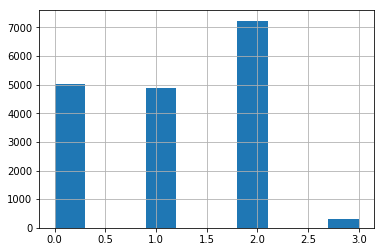

In [151]:
x_feature_merge.type_class.hist()

Split training and test set, 70% vs 30%

In [0]:
X = x_feature_merge.loc[:,["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]]
X = X.to_numpy()

In [0]:
y = x_feature_merge.type_class.to_numpy()

In [154]:
X.shape

(17456, 9)

In [0]:
# split training and testing
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Best on previous analysis random forest is the best predictor on frontmatter analysis so we use random forest

## Random Forest Classifier

In [158]:
from sklearn.ensemble import RandomForestClassifier
# Import metrics for computing accuracy
from sklearn import metrics

clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                              random_state=0)
clf_rf.fit(X_train, y_train)  
print(clf_rf.feature_importances_)

[0.08359281 0.21483933 0.03353708 0.11304666 0.09339836 0.03908331
 0.21575928 0.09322133 0.11352183]


In [159]:
y_hat = clf_rf.predict(X_test)
metrics.accuracy_score(y_test,y_hat)
print(metrics.classification_report(y_test,y_hat,target_names=type_list))

              precision    recall  f1-score   support

  no_content       0.84      0.91      0.88      1522
     factual       0.81      0.79      0.80      1459
    creative       0.89      0.89      0.89      2159
       mixed       0.30      0.06      0.10        97

    accuracy                           0.85      5237
   macro avg       0.71      0.66      0.67      5237
weighted avg       0.85      0.85      0.85      5237



# Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression

# logistic regression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_hat = clf_lr.predict(X_test)
acc = metrics.accuracy_score(y_test,y_hat) 
print(metrics.classification_report(y_test,y_hat,target_names=type_list))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

  no_content       0.82      0.88      0.85      1522
     factual       0.75      0.77      0.76      1459
    creative       0.90      0.86      0.88      2159
       mixed       0.00      0.00      0.00        97

    accuracy                           0.83      5237
   macro avg       0.62      0.63      0.62      5237
weighted avg       0.82      0.83      0.82      5237



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVC, with linear kernel

In [162]:
from sklearn.svm import LinearSVC
clf_svm_linear = LinearSVC(random_state=0, tol=1e-6,max_iter=10000)
clf_svm_linear.fit(X_train, y_train)  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-06,
          verbose=0)

In [163]:
y_hat = clf_svm_linear.predict(X_test)
metrics.accuracy_score(y_test,y_hat)
print(metrics.classification_report(y_test,y_hat,target_names=type_list))

              precision    recall  f1-score   support

  no_content       0.83      0.88      0.86      1522
     factual       0.71      0.81      0.76      1459
    creative       0.91      0.82      0.87      2159
       mixed       0.29      0.02      0.04        97

    accuracy                           0.82      5237
   macro avg       0.68      0.63      0.63      5237
weighted avg       0.82      0.82      0.82      5237



# How about detecting subtype

In [164]:
sub_type_list = x_feature_merge.sub_type.unique().tolist()
print(sub_type_list)

['no_content', 'title', 'pub_info', 'list', 'main_text', 'pref_text', 'cover', 'ad', 'image', 'appendix', 'dedication', 'poem', 'epigraph']


In [0]:
x_feature_merge["sub_type_class"] = x_feature_merge.sub_type.apply(lambda x:sub_type_list.index(x))

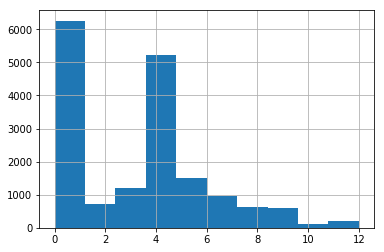

In [166]:
x_feature_merge.sub_type_class.hist()

Split training and test set, 70% vs 30%

In [0]:
X = x_feature_merge.loc[:,["line_count","token_count","empty_line_count","total_sentence","total_capital","total_numeric","pct_begin_char_caps","pct_end_numeric","pct_all_caps"]]
X = X.to_numpy()

In [0]:
y = x_feature_merge.sub_type_class.to_numpy()

In [169]:
X.shape

(17456, 9)

In [0]:
# split training and testing
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [177]:
from sklearn.ensemble import RandomForestClassifier
# Import metrics for computing accuracy
from sklearn import metrics

clf_rf = RandomForestClassifier(n_estimators=200, max_depth=20,
                              random_state=0)
clf_rf.fit(X_train, y_train)  
print(clf_rf.feature_importances_)

[0.10720948 0.23389896 0.04106962 0.13191331 0.09286788 0.04832677
 0.15560967 0.07994476 0.10915954]


In [181]:
y_hat = clf_rf.predict(X_test)
metrics.accuracy_score(y_test,y_hat)
print(metrics.classification_report(y_test,y_hat, target_names=sub_type_list))

              precision    recall  f1-score   support

  no_content       0.83      0.92      0.87      1522
       title       0.58      0.57      0.58       383
    pub_info       0.44      0.40      0.42       208
        list       0.76      0.75      0.75       354
   main_text       0.73      0.88      0.79      1560
   pref_text       0.49      0.29      0.37       450
       cover       0.32      0.23      0.27       153
          ad       0.30      0.15      0.20       132
       image       0.36      0.15      0.21       191
    appendix       0.65      0.57      0.61       190
  dedication       0.27      0.18      0.22        39
        poem       0.50      0.33      0.39        43
    epigraph       0.00      0.00      0.00        12

    accuracy                           0.70      5237
   macro avg       0.48      0.42      0.44      5237
weighted avg       0.67      0.70      0.68      5237



In [0]:
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

Normalized confusion matrix


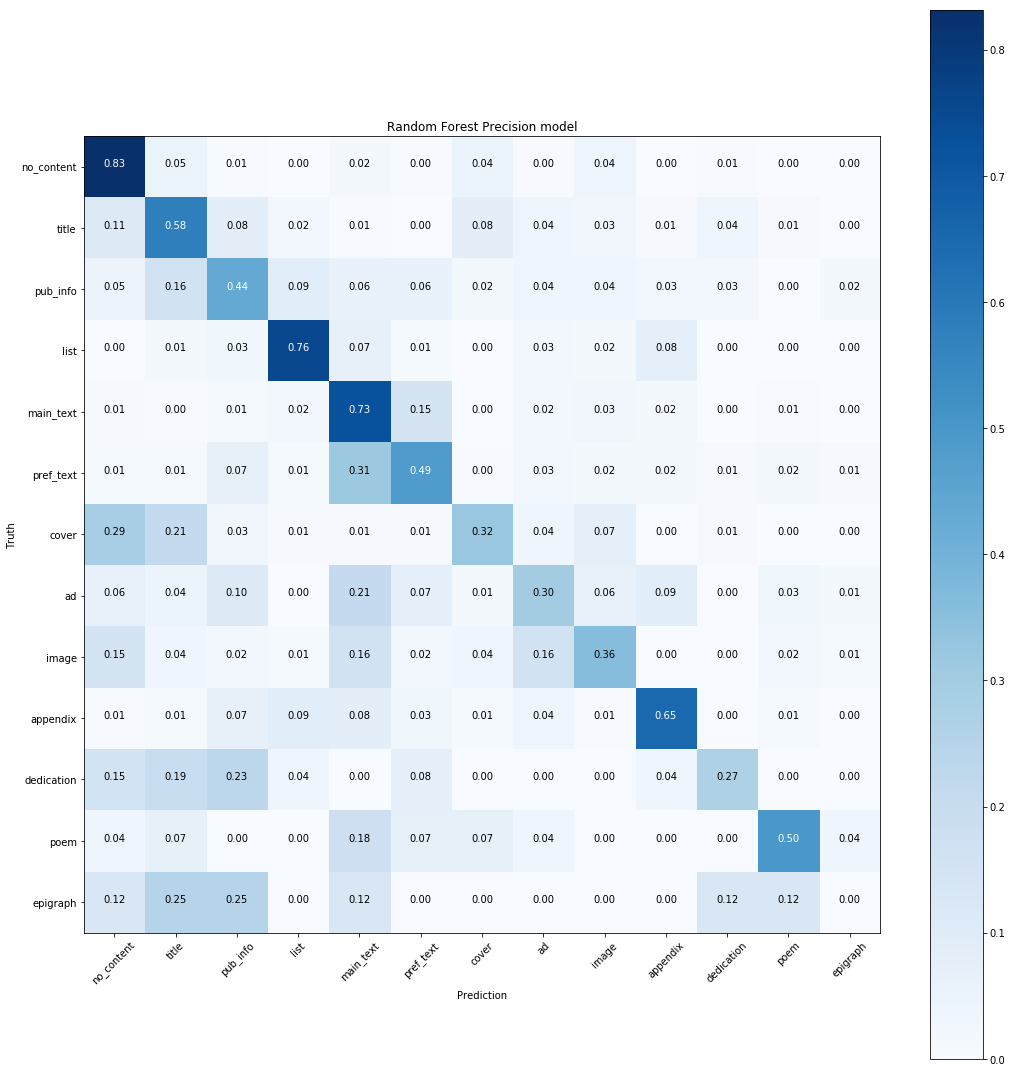

In [183]:
import numpy as np
cnf_matrix = confusion_matrix(y_hat,y_test)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=sub_type_list, normalize=True,
                      title="{} model".format("Random Forest Precision"))

# Logistic Regression

In [173]:
from sklearn.linear_model import LogisticRegression

# logistic regression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_hat = clf_lr.predict(X_test)
acc = metrics.accuracy_score(y_test,y_hat) 
print(metrics.classification_report(y_test,y_hat,target_names=sub_type_list))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

  no_content       0.74      0.91      0.82      1522
       title       0.43      0.61      0.50       383
    pub_info       0.08      0.01      0.02       208
        list       0.60      0.64      0.62       354
   main_text       0.64      0.93      0.76      1560
   pref_text       0.00      0.00      0.00       450
       cover       0.25      0.01      0.01       153
          ad       0.25      0.01      0.01       132
       image       0.25      0.01      0.01       191
    appendix       0.54      0.37      0.44       190
  dedication       0.00      0.00      0.00        39
        poem       0.00      0.00      0.00        43
    epigraph       0.00      0.00      0.00        12

    accuracy                           0.64      5237
   macro avg       0.29      0.27      0.25      5237
weighted avg       0.52      0.64      0.56      5237



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVC, with linear kernel

In [174]:
from sklearn.svm import LinearSVC
clf_svm_linear = LinearSVC(random_state=0, tol=1e-6,max_iter=10000)
clf_svm_linear.fit(X_train, y_train)  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-06,
          verbose=0)

In [175]:
y_hat = clf_svm_linear.predict(X_test)
metrics.accuracy_score(y_test,y_hat)
print(metrics.classification_report(y_test,y_hat, target_names=sub_type_list))

              precision    recall  f1-score   support

  no_content       0.76      0.91      0.83      1522
       title       0.44      0.64      0.52       383
    pub_info       0.32      0.36      0.34       208
        list       0.66      0.60      0.63       354
   main_text       0.64      0.92      0.76      1560
   pref_text       0.00      0.00      0.00       450
       cover       0.37      0.07      0.11       153
          ad       0.00      0.00      0.00       132
       image       0.00      0.00      0.00       191
    appendix       0.77      0.17      0.28       190
  dedication       0.00      0.00      0.00        39
        poem       0.00      0.00      0.00        43
    epigraph       0.00      0.00      0.00        12

    accuracy                           0.65      5237
   macro avg       0.31      0.28      0.27      5237
weighted avg       0.54      0.65      0.58      5237



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# New approach using extracted features (EF)

In [188]:
x_fact_page_df.head()

,vol_id,page,type,sub_type,add
0,chi.40727635,0,no_content,no_content,
1,chi.40727635,1,no_content,no_content,stamp
2,chi.40727635,2,no_content,no_content,
3,chi.40727635,3,no_content,no_content,
4,chi.40727635,4,factual,title,


In [201]:
#--- no need to run this because we created the extracted features dataframe
all_ef_page = []
with open("ef-fact-creat-vols.json","r") as file:
  i = 0
  for line in file:
    #print(line)
    test = jsonpickle.loads(line)
    #all_ef.append(test)
    all_pages = list(test.pages())
    # check the sequence on the dataset
    
    print(test.volume_identifier)
    for page in x_fact_page_df[x_fact_page_df.vol_id==test.volume_identifier].page.values:
      # seq start from 1, pages index processor start from 0
      try:
        all_ef_page.append((test.volume_identifier,int(page),all_pages[int(page)].tokenlist()))
      except:
        # exception happened if the volume does not have up to 19 pages, we will just skip it
        # all_ef_page.append((test.volume_identifier,int(page),None))
        pass
    i+=1
    #break

chi.40727635
coo.31924000431662
coo.31924001144959
coo.31924073896007
coo.31924080009719
coo.31924094241217
coo.31924098538329
ien.35556003776788
inu.30000070597756
inu.30000081728184
inu.30000093900276
inu.30000115509105
inu.30000115798963
inu.30000117802359
inu.32000007770185
inu.39000001168165
mdp.39015000426158
mdp.39015002985037
mdp.39015006404092
mdp.39015009147821
mdp.39015012654490
mdp.39015018230873
mdp.39015021525475
mdp.39015028575051
mdp.39015028686320
mdp.39015035384133
mdp.39015041878987
mdp.39015041920581
mdp.39015046811660
mdp.39015054437911
mdp.39015058723985
mdp.39015058747786
mdp.39015059268014
mdp.39015059314008
mdp.39015062118842
mdp.39015063635422
mdp.39015065053715
mdp.39015067434657
mdp.39015069671421
mdp.39015070446375
mdp.39015071112745
mdp.39015073956255
mdp.39015074369391
mdp.39015078660712
osu.32435057700403
pst.000004758006
pst.000068531966
txu.059172146813022
txu.059173001429689
txu.059173012302588
txu.059173018072390
txu.059173026695219
uc1.$b137867
uc1.

In [200]:
len(all_pages)

14

In [0]:
# save as pickle binary
--- only used first time
import pickle
with open("selected_ef_fact_creat.pickle","wb") as file:
  pickle.dump(all_ef_page,file)

In [0]:
# read pickle binary 
import pickle
with open("selected_ef_fact_creat.pickle","rb") as file:
  all_ef_page = pickle.load(file)

In [0]:
all_ef_page_pd = pd.DataFrame(all_ef_page,columns=["vol_id","page","features"])

In [205]:
all_ef_page_pd.head()

,vol_id,page,features
0,chi.40727635,0,"Empty DataFrame Columns: [page, section, token..."
1,chi.40727635,1,"Empty DataFrame Columns: [page, section, token..."
2,chi.40727635,2,"Empty DataFrame Columns: [page, section, token..."
3,chi.40727635,3,count page section tok...
4,chi.40727635,4,count page sec...


## get all unique features from the ef to build a feature set and term frequency matrix

In [0]:
feature_dict = {}
index = 0
for ef in all_ef_page_pd.features.values:
  for x in ef.reset_index().token.values:
    try:
      feature_dict[x]
    except:
      feature_dict[x] = index
      index+=1

In [207]:
# total features
total_features = len(feature_dict.keys())
total_features

469424

## make a term frequency matrix for each page, using sparse matrix because it will consume too much memory if we fit all the data in a regular matrix form

In [0]:
from scipy.sparse import lil_matrix

In [0]:
term_matrix = lil_matrix((all_ef_page_pd.shape[0],total_features))
for i,ef in enumerate(all_ef_page_pd.features.values):
  for x in ef.reset_index().values:
    #print(x[2])
    term_matrix[i,feature_dict[x[2]]] = x[4]
    #break
  #break
  #term_matrix[i,feature_dict[x]] = 

In [0]:
all_ef_page_merge_pd = all_ef_page_pd.merge(x_fact_page_df,left_on=["vol_id","page"],right_on=["vol_id","page"])

In [220]:
all_ef_page_pd.shape

(17456, 3)

In [221]:
all_ef_page_merge_pd.shape

(17456, 6)

In [222]:
term_matrix.shape

(17456, 469424)

In [223]:
sub_type_list = x_feature_merge.sub_type.unique().tolist()
print(sub_type_list)

['no_content', 'title', 'pub_info', 'list', 'main_text', 'pref_text', 'cover', 'ad', 'image', 'appendix', 'dedication', 'poem', 'epigraph']


In [0]:
all_ef_page_merge_pd["sub_type_class"] = x_feature_merge.sub_type.apply(lambda x:sub_type_list.index(x))

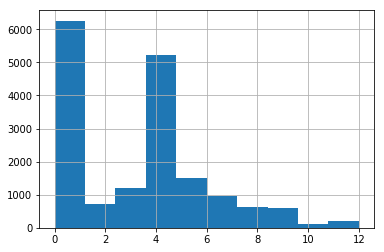

In [225]:
all_ef_page_merge_pd.sub_type_class.hist()

Split training and test set, 70% vs 30%

In [0]:
y = all_ef_page_merge_pd.sub_type_class.to_numpy()

In [0]:
# split training and testing
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(7)
X_train, X_test, train_index, test_index = train_test_split(term_matrix, y, test_size=0.30)

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
sgd_classifier = SGDClassifier()

In [230]:
sgd_classifier.fit(X_train,train_index)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
y_hat = sgd_classifier.predict(X_test)

In [232]:
metrics.accuracy_score(test_index,y_hat)
print(metrics.classification_report(test_index,y_hat))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1522
           1       0.38      0.54      0.45       383
           2       0.45      0.65      0.53       208
           3       0.78      0.66      0.71       354
           4       0.84      0.82      0.83      1560
           5       0.58      0.57      0.57       450
           6       0.14      0.09      0.11       153
           7       0.57      0.26      0.35       132
           8       0.29      0.17      0.22       191
           9       0.70      0.51      0.59       190
          10       0.38      0.28      0.32        39
          11       0.88      0.33      0.47        43
          12       0.15      0.17      0.16        12

    accuracy                           0.70      5237
   macro avg       0.54      0.46      0.48      5237
weighted avg       0.70      0.70      0.70      5237



Normalized confusion matrix


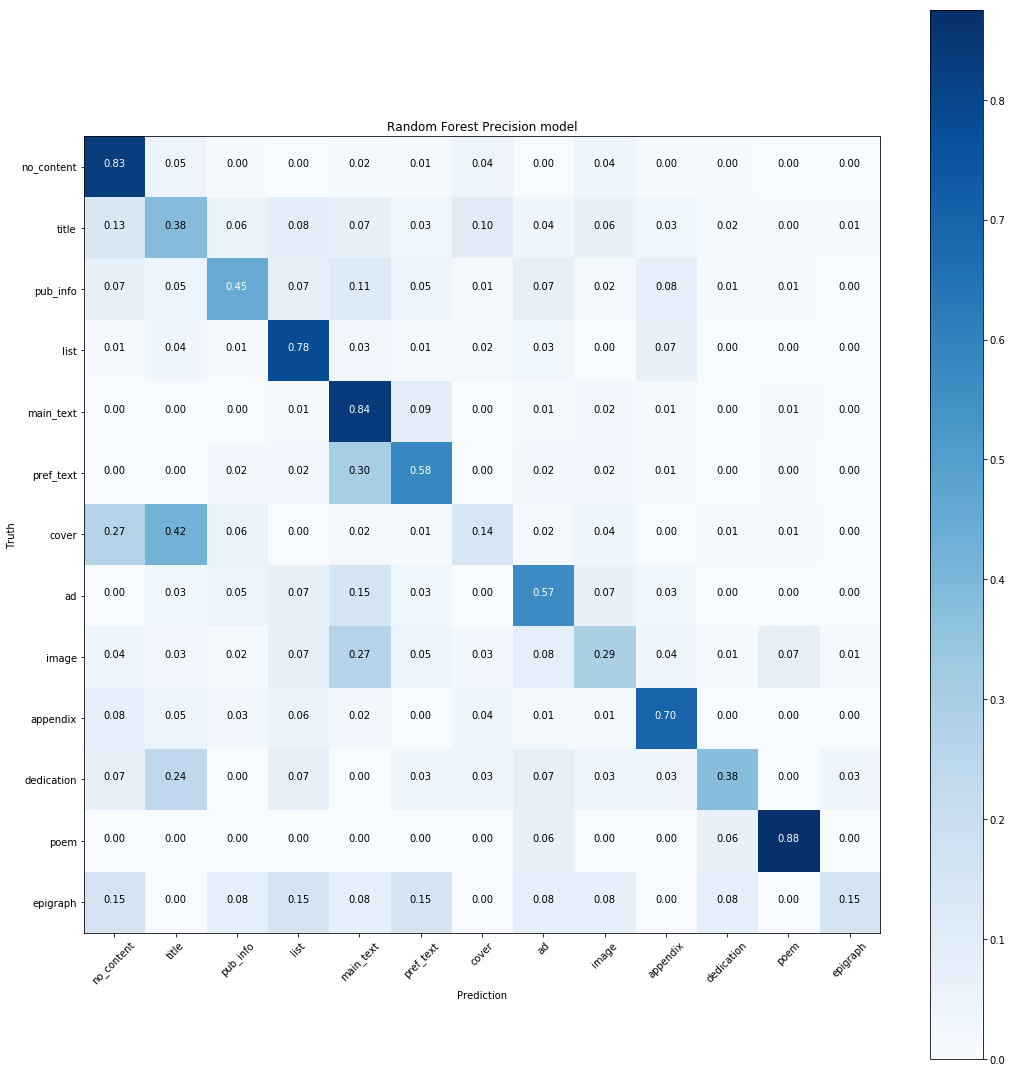

In [233]:
import numpy as np
cnf_matrix = confusion_matrix(y_hat,test_index)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=sub_type_list, normalize=True,
                      title="{} model".format("Random Forest Precision"))